<a href="https://colab.research.google.com/github/AndrewKalil/Udacity-ML/blob/master/Starbucks_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

###### portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

###### profile.json

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

###### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Library imports**

In [1]:
!pip install dython
!pip install klib
!pip install jupyterthemes
!pip install pandas-profiling==2.10.0

In [2]:

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from pandas.io.json import json_normalize
from dython.nominal import associations

from sklearn import preprocessing

# Visualización de missing values
import missingno as msno

import klib
%matplotlib inline

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Tema JupyterNotebook
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


import warnings
warnings.filterwarnings('ignore')

We then ahead and import the dataset files and dispay their content. 

In [3]:
# read potfolio.json
portfolio = pd.read_json('drive/MyDrive/Udacity/Datasets/portfolio.json', orient='records', lines=True)
portfolio



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# read profile.json
profile = pd.read_json('drive/MyDrive/Udacity/Datasets/profile.json', orient='records', lines=True)
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
# read transcript.json
transcript = pd.read_json('drive/MyDrive/Udacity/Datasets/transcript.json', orient='records', lines=True)
transcript


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### Keep in mind that the person who recieves a discound may not know that there was an offer


In [6]:
transcript = transcript.rename(columns={"person": "user_id"})
transcript

,user_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### No we look for missing values

In [7]:
# Missing values in portfolio
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [8]:
# Missing values in profile
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [9]:
# Percentage of missing value in profile
print("The percentage of missing values in profile is {}%".format(round(( profile.isnull().sum()[0] / profile.shape[0]) * 100,2)))

The percentage of missing values in profile is 12.79%


In [10]:
# Missing values in Transcript
transcript.isnull().sum()

user_id    0
event      0
value      0
time       0
dtype: int64

### Now let us go ahead and explore some important features of the data

In [11]:
transcript.groupby('event').count()

,user_id,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


We can notice that out of the offers received (76277), 57725 were viewed and 33579 were completed. This is important to keep in mind for future calculations


In [12]:
offers_completed = transcript.groupby('event').count()['user_id'][0]
offers_received = transcript.groupby('event').count()['user_id'][1]
offers_viewed = transcript.groupby('event').count()['user_id'][2]

print("Out of {} offers received, {}% were viewed and {}% were completed".format(offers_received, round(offers_viewed / offers_received * 100, 2), round(offers_completed / offers_received * 100, 2)))

Out of 76277 offers received, 75.68% were viewed and 44.02% were completed


### Preparing for merge

We notice that each table has a relationship with atleast one other table. Transcript and profile are related by user id. However in profile the column name for user id is just "id". To keep a better track of the data and to facilitate many things later, we will go ahead and rename the column to "user_id".

In [13]:
profile = profile.rename(columns={"id": "user_id"})
profile

,gender,age,user_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### *First Merge: Transcript and Portfolio*
Now we will go ahead and merge these two previously mentioned tables on "user_id" and we will drop the column that tells us when a user became a memeber.

In [14]:
ProfileTranscript = pd.merge(transcript,
                 profile,
                 on='user_id')
ProfileTranscript.drop('became_member_on', inplace=True, axis=1)
ProfileTranscript

,user_id,event,value,time,gender,age,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,100000.0
...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,78000.0
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,78000.0


### Extracting important values from profile

In [15]:
import datetime

cleaned_profile = profile.copy()

#Dropping rows with null information
cleaned_profile.dropna(inplace = True)

#Changing 'id' column name to more appropriate 'customer_id' name
cleaned_profile.rename(columns = {'id': 'user_id'}, inplace = True)

#Changing 'became_member_on' column to a date type
cleaned_profile['became_member_on'] = cleaned_profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())

#Calculating number of days as a member 
end = pd.Timestamp('2021-06-01')
end = pd.to_datetime(end)
cleaned_profile['days_as_member'] = np.abs((pd.to_datetime(cleaned_profile['became_member_on']) - end).dt.days)

#Creating 'age_range' column based on 'age'
age_range_list = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
cleaned_profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_list, right = False)

cleaned_profile

,gender,age,user_id,became_member_on,income,days_as_member,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1417,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1484,70-79
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1132,60-69
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1208,60-69
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1298,50-59
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1093,40-49
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,1054,60-69
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1587,40-49
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1912,80+


### Extracting important values from transcript

In [16]:
event_dummies =  pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript_dataset = pd.concat([transcript, event_dummies], axis = 1)
transcript_dataset['days'] = transcript_dataset['time'] / 24
transcript_dataset.drop(columns = ['time'], inplace = True)
transcript_dataset

,user_id,event,value,offer_completed,offer_received,offer_viewed,transaction,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,0.00
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0.00
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,0.00
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},0,0,0,1,29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},0,0,0,1,29.75
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},0,0,0,1,29.75
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},0,0,0,1,29.75


In [17]:
# separate value columns into different columns
transcript_dataset['offer-or-amount'] = transcript_dataset['value'].apply(lambda x: list(x.keys())[0])
transcript_dataset['id-or-amount'] = transcript_dataset['value'].apply(lambda x: list(x.values())[0])

# changing all offer ids to a unified name: offer_id
trans_offer_dict = {'offer id': 'offer_id'}
transcript_dataset['offer-or-amount'].replace({'offer id':'offer_id'}, inplace = True)
transcript_dataset

,user_id,event,value,offer_completed,offer_received,offer_viewed,transaction,days,offer-or-amount,id-or-amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,0.00,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0.00,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,0.00,offer_id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,0.00,offer_id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,0.00,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},0,0,0,1,29.75,amount,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},0,0,0,1,29.75,amount,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},0,0,0,1,29.75,amount,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},0,0,0,1,29.75,amount,3.53


In [102]:
# Creating the offer DataFrame for transcript dataset
transcript_dataset_offer = transcript_dataset[transcript_dataset['offer-or-amount'] == 'offer_id']
transcript_dataset_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_dataset_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)
transcript_dataset_offer


,user_id,offer_completed,offer_received,offer_viewed,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,1,0,0.00,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0.00,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,1,0,0,29.75,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,1,0,0,29.75,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,0,0,1,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,1,0,0,29.75,fafdcd668e3743c1bb461111dcafc2a4


In [19]:
# Creating the amount DataFrame for transcript dataset
transcript_dataset_amount = transcript_dataset[transcript_dataset['offer-or-amount'] == 'amount']
transcript_dataset_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_dataset_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)
transcript_dataset_amount

,user_id,transaction,days,amount
12654,02c083884c7d45b39cc68e1314fec56c,1,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,1,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,1,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,1,0.00,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,1,29.75,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,1,29.75,9.53
306531,a00058cf10334a308c68e7631c529907,1,29.75,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,1,29.75,3.53


In [20]:
cleaned_transcript = transcript.copy()
#Changing the 'person' column name to 'user_id'
cleaned_transcript.rename(columns = {'person': 'user_id'}, inplace = True)

# One hot encode event values
event_dummies = pd.get_dummies(cleaned_transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
cleaned_transcript = pd.concat([cleaned_transcript, event_dummies], axis = 1)

# Change 'time' column to 'days' along with the appropriate values
cleaned_transcript['days'] = cleaned_transcript['time'] / 24
cleaned_transcript.drop(columns = ['time'], inplace = True)

# separate value columns into different columns
cleaned_transcript['offer-or-amount'] = cleaned_transcript['value'].apply(lambda x: list(x.keys())[0])
cleaned_transcript['id-or-amount'] = cleaned_transcript['value'].apply(lambda x: list(x.values())[0])

# changing all offer ids to a unified name: offer_id
trans_offer_dict = {'offer id': 'offer_id'}
cleaned_transcript['offer-or-amount'].replace({'offer id':'offer_id'}, inplace = True)

# Creating the offer DataFrame for transcript dataset
transcript_dataset_offer = cleaned_transcript[cleaned_transcript['offer-or-amount'] == 'offer_id']
transcript_dataset_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_dataset_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

# Creating the amount DataFrame for transcript dataset
transcript_dataset_amount = cleaned_transcript[cleaned_transcript['offer-or-amount'] == 'amount']
transcript_dataset_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_dataset_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)
transcript_dataset_amount

# transcript_offer_clean, transcript_amount_clean = clean_transcript()
# print(transcript_offer_clean)
# print(transcript_amount_clean)

,user_id,transaction,days,amount
12654,02c083884c7d45b39cc68e1314fec56c,1,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,1,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,1,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,1,0.00,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,1,29.75,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,1,29.75,9.53
306531,a00058cf10334a308c68e7631c529907,1,29.75,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,1,29.75,3.53


### Extracting important values from portfolio

In [21]:
cleaned_portfolio = portfolio.copy()

# creating a unified identifier for the ids of offers: offer_id
cleaned_portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

# One hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(cleaned_portfolio['offer_type'], prefix = 'offer')
cleaned_portfolio = pd.concat([cleaned_portfolio, offer_dummies], axis = 1)
cleaned_portfolio.drop(columns=['offer_type'], inplace=True)

#Separating and one hot encoding the channels field
channels_one_hot = preprocessing.MultiLabelBinarizer()
sep_channels = channels_one_hot.fit_transform(cleaned_portfolio['channels'])
channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)
cleaned_portfolio = pd.concat([cleaned_portfolio, channels_df], axis = 1)
cleaned_portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)
cleaned_portfolio.drop(columns=['channels'], inplace=True)
cleaned_portfolio 
# portfolio[portfolio['offer_type'] == 'discount']['id'].to_list()

#Dropping the now former columns
# cleaned_portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)

,reward,difficulty,duration,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


### Merging

In [106]:
def unify_dataset(user_ids, portfolio, cleaned_portfolio, cleaned_profile, transcript_dataset_offer, transcript_dataset_amount):
    
    #Initializing a list to append our individual customer dictionaries to
    entries = []
    
    for user_id in user_ids:
        # Extracting user attributes
        user = cleaned_profile[cleaned_profile['user_id'] == user_id]
        age = user['age'].values[0]
        became_member_on = user['became_member_on'].values[0]
        gender = user['gender'].values[0]
        income = user['income'].values[0]
        age_range = user['age_range'].values[0]

        # New features to be added
        total_viewed = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_viewed'].sum()
        total_received = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_received'].sum()
        total_completed = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_completed'].sum()
        total_spent = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['amount'].sum()
        avg_spent = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['amount'].mean()
        num_transactions = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['transaction'].sum()

        # percentages of completed and viewed
        percent_viewed = round(total_viewed / total_received * 100, 2)
        percent_completed = round(total_completed / total_received * 100, 2)

        # Completed offers
        offer_completed_df = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = cleaned_portfolio[cleaned_portfolio['offer_id'].isin(completed_offer_list)]['offer_bogo'].sum()
        completed_discount = cleaned_portfolio[cleaned_portfolio['offer_id'].isin(completed_offer_list)]['offer_discount'].sum()

        # Offers received
        offers_received = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_id'].values.tolist()
        bogos = portfolio[portfolio['offer_type'] == 'bogo']['id'].to_list()
        discounts = portfolio[portfolio['offer_type'] == 'discount']['id'].to_list()
        
        #Initializing variables we will use later on down
        discounts_received = 0
        bogos_received = 0

        #Determining whether or not offer is a bogo or discount offer and incrementing appropriate variables
        for offer in offers_received:
            #Iterating through all the bogo offers
            if offer in bogos:
                bogos_received += 1
            #Iterating through all the discount offers
            elif offer in discounts:
                discounts_received += 1

        #Determining the percentage of bogo & discount offers actually completed versus how many of each were offered
        if bogos_received > 0:
            bogo_percent_completed = completed_bogo / bogos_received
        else:
            bogo_perecent_completed = 0.0

        if discounts_received > 0:
            discount_percent_completed = completed_discount / discounts_received
        else:
            discount_percent_completed = 0.0

        #Adding all features to a unified dictionary, 'person_entry'
        person_entry = {'user_id': user_id,
                        'age': age,
                        'gender': gender,
                        'income': income,
                        'became_member_on': became_member_on,
                        'total_completed': total_completed,
                        'total_viewed': total_viewed,
                        'total_received': total_received,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions,
                        'bogos_received': bogos_received,
                        'completed_bogo': completed_bogo,
                        'discounts_received': discounts_received,
                        'completed_discount': completed_discount,
                        'discount_percent_completed': discount_percent_completed,
                        'bogo_percent_completed': bogo_percent_completed,
                        'percent_viewed': percent_viewed,
                        'percent_completed': percent_completed}

        entries.append(person_entry)
    
    #Building our final DataFrame from the entries list
    unified_dataset = pd.DataFrame(entries)
    unified_dataset.to_csv('drive/MyDrive/Udacity/unified_dataset.csv')
    
    return unified_dataset

### Calling the function to generate the unified dataset

In [120]:
# Loop through the customer base and collect data from other datasets
user_ids = cleaned_profile['user_id'].to_list()
# unified_dataset = unify_dataset(user_ids, portfolio, cleaned_portfolio, cleaned_profile, transcript_dataset_offer, transcript_dataset_amount)
unified_dataset = pd.read_csv('drive/MyDrive/Udacity/unified_dataset.csv')
unified_dataset.drop(columns=["Unnamed: 0", 'user_id'], inplace=True)
unified_dataset

,age,gender,income,became_member_on,total_completed,total_viewed,total_received,total_spent,avg_spent,num_transactions,bogos_received,completed_bogo,discounts_received,completed_discount,discount_percent_completed,bogo_percent_completed,percent_viewed,percent_completed
0,55,F,112000.0,2017-07-15,1,0,2,77.01,25.670000,3,2,1,0,0,0.000000,0.500000,0.00,50.00
1,75,F,100000.0,2017-05-09,3,4,4,159.27,22.752857,7,9,3,0,0,0.000000,0.333333,100.00,75.00
2,68,M,70000.0,2018-04-26,2,3,4,57.73,19.243333,3,3,1,5,2,0.400000,0.333333,75.00,50.00
3,65,M,53000.0,2018-02-09,5,6,6,36.43,12.143333,3,11,2,6,2,0.333333,0.181818,100.00,83.33
4,58,M,51000.0,2017-11-11,1,2,3,15.62,3.905000,4,0,0,5,2,0.400000,0.181818,66.67,33.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,45,F,54000.0,2018-06-04,0,3,3,20.03,2.861429,7,2,1,2,1,0.500000,0.500000,100.00,0.00
14821,61,M,72000.0,2018-07-13,1,1,3,25.97,3.710000,7,2,1,0,0,0.000000,0.500000,33.33,33.33
14822,49,M,73000.0,2017-01-26,0,1,3,39.74,4.967500,8,0,0,1,1,1.000000,0.500000,33.33,0.00
14823,83,F,50000.0,2016-03-07,3,3,3,189.67,13.547857,14,9,3,0,0,0.000000,0.333333,100.00,100.00


### Adding columns for categorization

In [121]:
#Creating 'age_range' column based on 'age'
age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
unified_dataset['age_range'] = pd.cut(unified_dataset['age'], bins = age_range_bins, labels = age_range_labels, right = False)
unified_dataset.drop('age', axis= 1, inplace=True)

#Creating 'num_transactions_range' column based on 'num_transactions'
num_transactions_range_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30+']
num_transactions_range_bins = [0, 5, 10, 15, 20, 25, 30, 50]
unified_dataset['num_transactions_range'] = pd.cut(unified_dataset['num_transactions'], bins = num_transactions_range_bins, labels = num_transactions_range_labels, right = False)
unified_dataset.drop('num_transactions', axis= 1, inplace=True)

#Creating 'bogos_received_range' column based on 'bogos_received'
bogos_received_range_labels = ['0-4', '5-9', '10-14', '15+']
bogos_received_range_bins = [0, 5, 10, 15, 25]
unified_dataset['bogos_received_range'] = pd.cut(unified_dataset['bogos_received'], bins = bogos_received_range_bins, labels = bogos_received_range_labels, right = False)
unified_dataset.drop('bogos_received', axis= 1, inplace=True)

#Creating 'discounts_received_range' column based on 'discounts_received'
discounts_received_range_labels = ['0-4', '5-9', '10-14', '15+']
discounts_received_range_bins = [0, 5, 10, 15, 25]
unified_dataset['discounts_received_range'] = pd.cut(unified_dataset['discounts_received'], bins = discounts_received_range_bins, labels = discounts_received_range_labels, right = False)
unified_dataset.drop('discounts_received', axis= 1, inplace=True)

#Creating 'percent_viewed_range' column based on 'percent_viewed'
percent_viewed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
percent_viewed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
unified_dataset['percent_viewed_range'] = pd.cut(unified_dataset['percent_viewed'], bins = percent_viewed_range_bins, labels = percent_viewed_range_labels, right = False)
unified_dataset.drop('percent_viewed', axis= 1, inplace=True)

#Creating 'percent_completed_range' column based on 'percent_completed'
percent_completed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
percent_completed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
unified_dataset['percent_completed_range'] = pd.cut(unified_dataset['percent_completed'], bins = percent_completed_range_bins, labels = percent_completed_range_labels, right = False)
unified_dataset.drop('percent_completed', axis= 1, inplace=True)

unified_dataset.drop('became_member_on', axis= 1, inplace=True)
unified_dataset

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,discount_percent_completed,bogo_percent_completed,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range
0,F,112000.0,1,0,2,77.01,25.670000,1,0,0.000000,0.500000,50-59,0-4,0-4,0-4,0-9,50-59
1,F,100000.0,3,4,4,159.27,22.752857,3,0,0.000000,0.333333,70-79,5-9,5-9,0-4,90-100,70-79
2,M,70000.0,2,3,4,57.73,19.243333,1,2,0.400000,0.333333,60-69,0-4,0-4,5-9,70-79,50-59
3,M,53000.0,5,6,6,36.43,12.143333,2,2,0.333333,0.181818,60-69,0-4,10-14,5-9,90-100,80-89
4,M,51000.0,1,2,3,15.62,3.905000,0,2,0.400000,0.181818,50-59,0-4,0-4,5-9,60-69,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,54000.0,0,3,3,20.03,2.861429,1,1,0.500000,0.500000,40-49,5-9,0-4,0-4,90-100,0-9
14821,M,72000.0,1,1,3,25.97,3.710000,1,0,0.000000,0.500000,60-69,5-9,0-4,0-4,30-39,30-39
14822,M,73000.0,0,1,3,39.74,4.967500,0,1,1.000000,0.500000,40-49,5-9,0-4,0-4,30-39,0-9
14823,F,50000.0,3,3,3,189.67,13.547857,3,0,0.000000,0.333333,80+,10-14,5-9,0-4,90-100,90-100


In [122]:
# Categorizing completed discounts percents
unified_dataset['discount_percent_completed2'] = round(unified_dataset['discount_percent_completed'] * 100, 2)
unified_dataset.drop(columns='discount_percent_completed', inplace=True) 
discount_percent_completed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
discount_percent_completed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
unified_dataset['discount_percent_completed_range'] = pd.cut(unified_dataset['discount_percent_completed2'], bins = discount_percent_completed_range_bins, labels = discount_percent_completed_range_labels, right = False)
unified_dataset.drop('discount_percent_completed2', axis= 1, inplace=True)

# Categorizing completed bogos percents
unified_dataset['bogo_percent_completed2'] = round(unified_dataset['bogo_percent_completed'] * 100, 2)
unified_dataset.drop(columns='bogo_percent_completed', inplace=True) 
bogo_percent_completed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
bogo_percent_completed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
unified_dataset['bogo_percent_completed_range'] = pd.cut(unified_dataset['bogo_percent_completed2'], bins = bogo_percent_completed_range_bins, labels = bogo_percent_completed_range_labels, right = False)
unified_dataset.drop('bogo_percent_completed2', axis= 1, inplace=True)

unified_dataset

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range,discount_percent_completed_range,bogo_percent_completed_range
0,F,112000.0,1,0,2,77.01,25.670000,1,0,50-59,0-4,0-4,0-4,0-9,50-59,0-9,50-59
1,F,100000.0,3,4,4,159.27,22.752857,3,0,70-79,5-9,5-9,0-4,90-100,70-79,0-9,30-39
2,M,70000.0,2,3,4,57.73,19.243333,1,2,60-69,0-4,0-4,5-9,70-79,50-59,40-49,30-39
3,M,53000.0,5,6,6,36.43,12.143333,2,2,60-69,0-4,10-14,5-9,90-100,80-89,30-39,10-19
4,M,51000.0,1,2,3,15.62,3.905000,0,2,50-59,0-4,0-4,5-9,60-69,30-39,40-49,10-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,54000.0,0,3,3,20.03,2.861429,1,1,40-49,5-9,0-4,0-4,90-100,0-9,50-59,50-59
14821,M,72000.0,1,1,3,25.97,3.710000,1,0,60-69,5-9,0-4,0-4,30-39,30-39,0-9,50-59
14822,M,73000.0,0,1,3,39.74,4.967500,0,1,40-49,5-9,0-4,0-4,30-39,0-9,90-100,50-59
14823,F,50000.0,3,3,3,189.67,13.547857,3,0,80+,10-14,5-9,0-4,90-100,90-100,0-9,30-39


### removing any null values

In [123]:
unified_dataset.isnull().sum()

gender                                0
income                                0
total_completed                       0
total_viewed                          0
total_received                        0
total_spent                           0
avg_spent                           333
completed_bogo                        0
completed_discount                    0
age_range                             0
num_transactions_range                0
bogos_received_range                  0
discounts_received_range              0
percent_viewed_range                  5
percent_completed_range               5
discount_percent_completed_range      0
bogo_percent_completed_range          0
dtype: int64

GridSpec(6, 6)

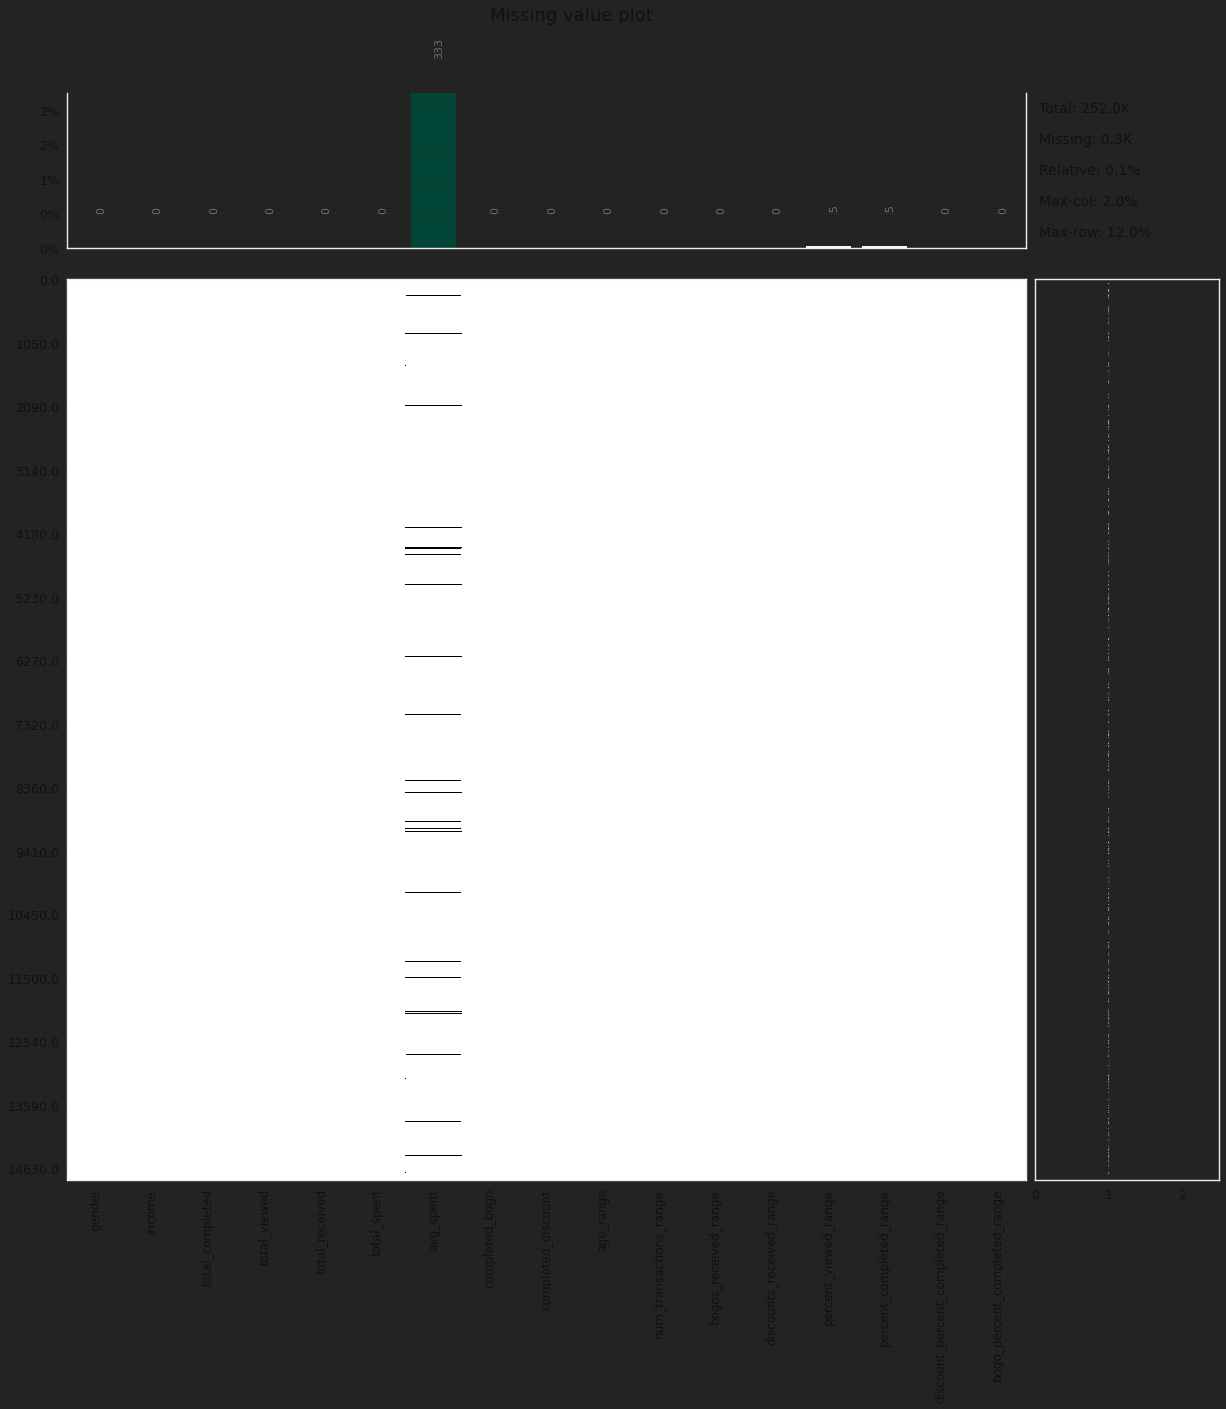

In [124]:
klib.missingval_plot(unified_dataset)

In [125]:
unified_dataset.dropna(inplace=True)
unified_dataset

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range,discount_percent_completed_range,bogo_percent_completed_range
0,F,112000.0,1,0,2,77.01,25.670000,1,0,50-59,0-4,0-4,0-4,0-9,50-59,0-9,50-59
1,F,100000.0,3,4,4,159.27,22.752857,3,0,70-79,5-9,5-9,0-4,90-100,70-79,0-9,30-39
2,M,70000.0,2,3,4,57.73,19.243333,1,2,60-69,0-4,0-4,5-9,70-79,50-59,40-49,30-39
3,M,53000.0,5,6,6,36.43,12.143333,2,2,60-69,0-4,10-14,5-9,90-100,80-89,30-39,10-19
4,M,51000.0,1,2,3,15.62,3.905000,0,2,50-59,0-4,0-4,5-9,60-69,30-39,40-49,10-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,54000.0,0,3,3,20.03,2.861429,1,1,40-49,5-9,0-4,0-4,90-100,0-9,50-59,50-59
14821,M,72000.0,1,1,3,25.97,3.710000,1,0,60-69,5-9,0-4,0-4,30-39,30-39,0-9,50-59
14822,M,73000.0,0,1,3,39.74,4.967500,0,1,40-49,5-9,0-4,0-4,30-39,0-9,90-100,50-59
14823,F,50000.0,3,3,3,189.67,13.547857,3,0,80+,10-14,5-9,0-4,90-100,90-100,0-9,30-39


### General Data report

In [126]:
# Portfolio report
report = ProfileReport(unified_dataset, title='Report for unified dataset V1', dataset={'creator':'Andrew Kalil'},
                        html={'style':{'full_width':True}})

report.to_file("final dataset.html")

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
# report 

### Statistical exploration of data

In [127]:
# Change data type float to int 
for y in unified_dataset.columns:
    if(unified_dataset[y].dtype == np.float64):
        unified_dataset[y] = unified_dataset[y].astype(int)
    

unified_dataset.dtypes

gender                                object
income                                 int64
total_completed                        int64
total_viewed                           int64
total_received                         int64
total_spent                            int64
avg_spent                              int64
completed_bogo                         int64
completed_discount                     int64
age_range                           category
num_transactions_range              category
bogos_received_range                category
discounts_received_range            category
percent_viewed_range                category
percent_completed_range             category
discount_percent_completed_range    category
bogo_percent_completed_range        category
dtype: object

In [128]:
unified_dataset.describe()

,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount
count,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000
mean,65219.990336,2.239525,3.363291,4.488162,119.246290,14.754331,1.489749,1.490992
std,21599.018396,1.564413,1.283693,1.070667,130.231559,16.547979,0.865536,0.871907
min,30000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,49000.000000,1.000000,2.000000,4.000000,34.000000,3.000000,1.000000,1.000000
50%,63000.000000,2.000000,3.000000,5.000000,89.000000,14.000000,1.000000,1.000000
75%,79000.000000,3.000000,4.000000,5.000000,162.000000,21.000000,2.000000,2.000000
max,120000.000000,6.000000,6.000000,6.000000,1608.000000,451.000000,4.000000,4.000000


In [130]:
###################### Useful Functions for later use ########################
def plot_percentage(ax, feature):
    """
    plot_percentage: Shows the percentage that the category represents in the overall data set.
    
    Parameteres
        plot: seaborn data type
        feature: Name of the feature of the dataset
        
    Return
        None    
    """
    
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def plot_category_variable(data, column):
    """
    plot_category_variable: Display plot of categorical variables 
    
    Paramters
        column: Name of the column of the dataframe to be displayed
        
    Return 
        None                
    """
    
    plt.figure(figsize=(8, 6)) 
    ax = sns.countplot(x=column, data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.suptitle('Frecuency of ' + column)

    plot_percentage(ax, data[column])

def plot_cat_num_variable(data, cat, num):
    """
    plot_category_variable: Display plot of categorical variables 
    
    Paramters
        column: Name of the column of the dataframe to be displayed
        
    Return 
        None                
    """
    
    plt.figure(figsize=(8, 6)) 
    ax = sns.barplot(x=cat, y = num, data = data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.suptitle(cat + ' Vs ' + num)
    
    plt.show()


#### Visualize gender category

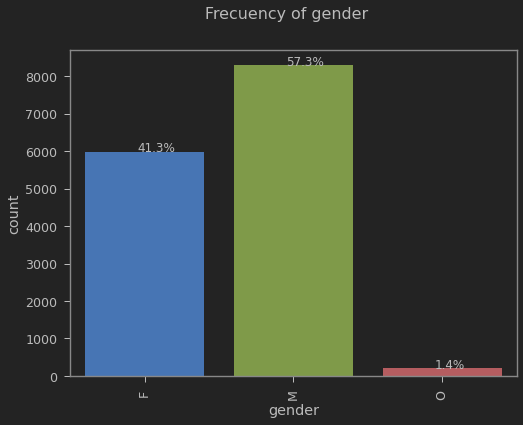

In [131]:
plot_category_variable(unified_dataset, 'gender')

This shows that there are more men than women in the customer base. 57.2% being men, 41.4% being women and 1.4% in the other category

#### Visualize incomes by gender

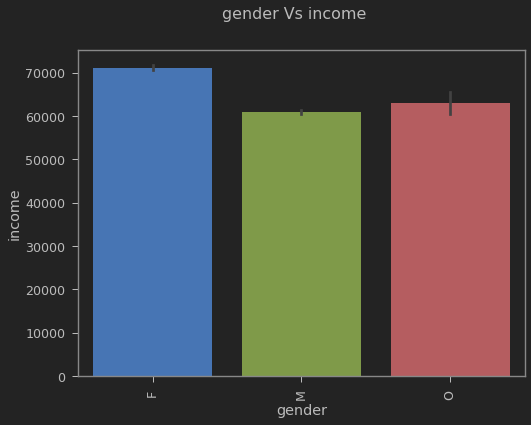

In [132]:
plot_cat_num_variable(unified_dataset, "gender", "income")

Here we can notice that women in this dataset have higher incomes than men do. 

#### Visualize Total spent by gender

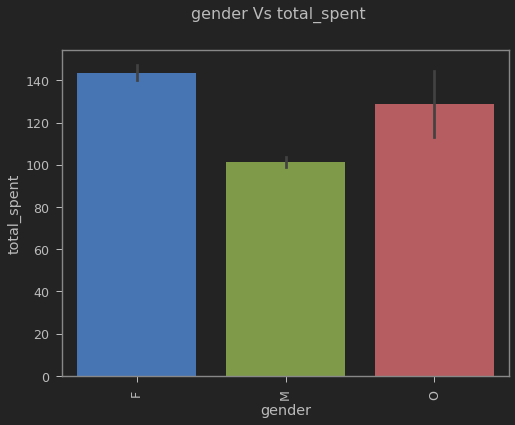

In [133]:
plot_cat_num_variable(unified_dataset, "gender", "total_spent")

Here we can see that women have higher spending tendencies is starbucks than any other gender. Men have the least spending tendendies in the dataset.

#### Visualize age groups by decades

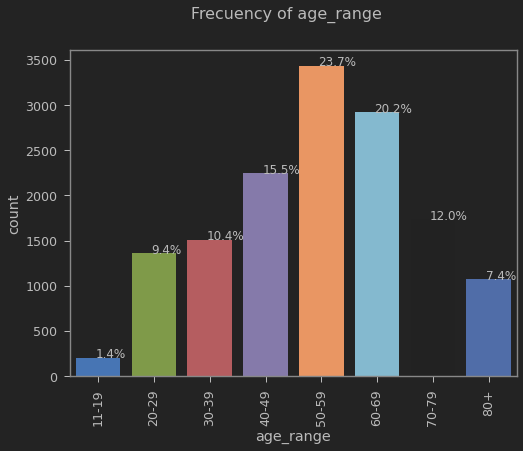

In [134]:
plot_category_variable(unified_dataset, 'age_range')

#### Visualize total offers completed

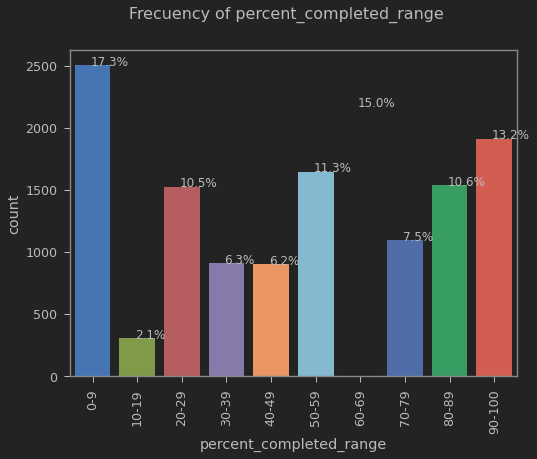

In [135]:
plot_category_variable(unified_dataset, 'percent_completed_range')

This graphic shows the percentage of people that completed a number of offers out of the ones that were sent to them.

#### Visualize total offers viewed

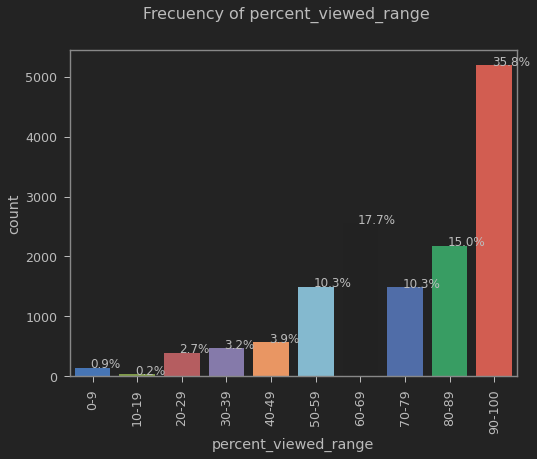

In [136]:
plot_category_variable(unified_dataset, 'percent_viewed_range')

#### Visualize groups of people that completed a percentage range of discount offers

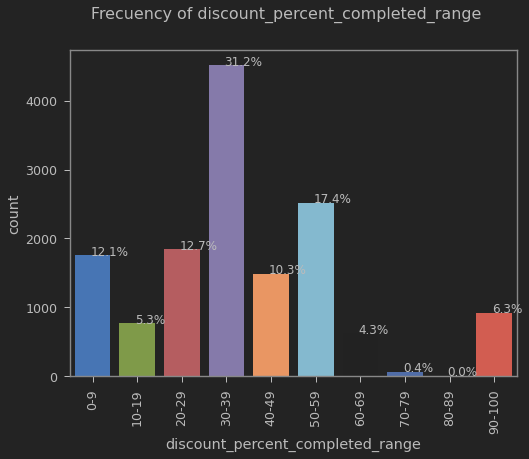

In [140]:
plot_category_variable(unified_dataset, 'discount_percent_completed_range')

#### Visualize groups of people that completed a percentage range of bogo offers

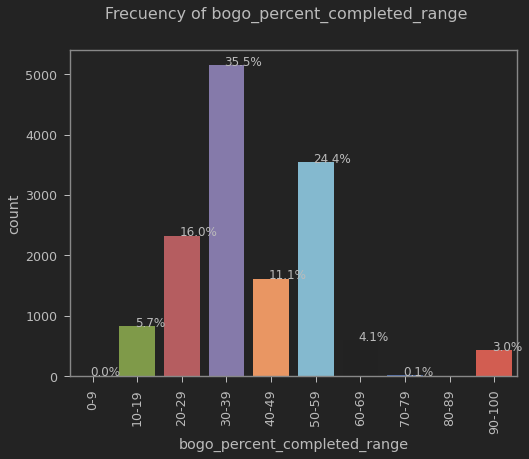

In [139]:
plot_category_variable(unified_dataset, 'bogo_percent_completed_range')

#### The Hopkins Statistics
This is used to test the spatial randomness of the data and indicates the clustering tendency and score of said data

In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

def hopkins(df):
    """
    hopkins: Take a dataframe and return the Hopkins statistic.
    
    Parameters
        df: Dataframe that takes the numerical values to extract the Hopkins statistic
        
     Return
         statistics_hopkins: Return of Hopkins statistician
    """

    d = df.shape[1]
    # d = len(vars) # columns
    n = len(df)  # rows
    m = int(0.1 * n)  # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(df.values)

    rand_df = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(df, axis=0), np.amax(
            df, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            df.iloc[rand_df[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    statistics_hopkins = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(statistics_hopkins):
        print(ujd, wjd)
        H = 0

    return statistics_hopkins   

In [ ]:
hopkins(final_data[numeric_features])


Now we will take a look at the data combinations created by these densities. And how they are affected by three different rescalers: Robust, Standard and Min Max

In [ ]:
columns = ['time', 'income']

scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(final_data[['time', 'income']])
robust_df = pd.DataFrame(robust_df, columns = columns)
  
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(final_data[['time', 'income']])
standard_df = pd.DataFrame(standard_df, columns = columns)
  
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(robust_df[['time', 'income']])
minmax_df = pd.DataFrame(minmax_df, columns = columns)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')
  
sns.kdeplot(final_data['income'], ax = ax1, color ='r')
sns.kdeplot(final_data['time'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')
  
sns.kdeplot(robust_df['income'], ax = ax2, color ='red')
sns.kdeplot(robust_df['time'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')
  
sns.kdeplot(standard_df['income'], ax = ax3, color ='black')
sns.kdeplot(standard_df['time'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')
  
sns.kdeplot(minmax_df['income'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['time'], ax = ax4, color ='g')
plt.show()

Preprocessing data function

In [ ]:
def preprocessing_data(df):
    """
    preprocessing_data: It receives a dataframe to which two rescalers RobustScaler and MinMaxScaler are applied.
    
    
    Paramters:
        df: Dataframe to transform.
        
    
    Return
        df: Dataframe columns age, time and income transformed.
    """
    
    
    num_features = ['time', 'income']
    cat_features = ['gender', 'channels', 'reward', 'difficulty', 'duration', 'offer_type']
    
    # Apply RobustScaler
    df[num_features] = preprocessing.RobustScaler().fit_transform(df[num_features])
    
    # Apply MinMaxScaler
    df[num_features] = preprocessing.MinMaxScaler().fit_transform(df[num_features])

    # Set preprocessor for categorical variables
    le = preprocessing.LabelEncoder()
    
    # Apply LabelEncoder
    df[cat_features] = df[cat_features].apply(le.fit_transform)

    return df   

In [ ]:

data_transform = preprocessing_data(final_data)
data_transform

#### The following is sort of a legend used to show what each of these number values in the rows stad for eg: 1, 2, 3, 4

**reward**
* 2: 0
* 3: 1
* 5: 2
* 10: 3

**channels**
* ['email', 'mobile', 'social']: 0
* ['web', 'email', 'mobile', 'social']: 1
* ['web', 'email', 'mobile']: 2
* ['web', 'email']: 3

**difficulty**
* 5: 0
* 7: 1
* 10: 2
* 20: 3

**duration**
* 5: 0
* 7: 1
* 10: 2

**offer type**
* bogo: 0
* discount: 1

**gender**
* F: 0
* M: 1
* O: 2


### Finally we go ahead and drop the user id since it is not really of any use to us anymore.

In [ ]:
data_transform.drop(columns=["user_id"], inplace=True, axis=1)
data_transform